In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

!pip install /kaggle/input/pgmpyh/pgmpy-0.1.26-py3-none-any.whl
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

Processing /kaggle/input/pgmpyh/pgmpy-0.1.26-py3-none-any.whl
pgmpy is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [5]:
data = pd.read_csv('/kaggle/input/credit/creditcardcsvpresent.csv')
data.replace({'Y': 1, 'N': 0}, inplace=True)
data

/tmp/ipykernel_30/2559221535.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'Y': 1, 'N': 0}, inplace=True)


,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,NaN,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,NaN,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,NaN,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,NaN,500.0,26000.0,0,0,1,1,800,677.2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3070,6661273532,NaN,500.0,11000.0,1,0,0,0,754,585.0,7,0
3071,6661273532,NaN,800.0,0.0,1,0,0,0,754,585.0,7,0
3072,6661273533,NaN,800.0,20800.0,1,0,0,0,754,585.0,7,0
3073,6661273532,NaN,1500.0,12000.0,1,0,1,1,754,585.0,7,0


In [7]:
data.isnull().sum()

Merchant_id                          0
Transaction date                  3075
Average Amount/transaction/day       0
Transaction_amount                   0
Is declined                          0
Total Number of declines/day         0
isForeignTransaction                 0
isHighRiskCountry                    0
Daily_chargeback_avg_amt             0
6_month_avg_chbk_amt                 0
6-month_chbk_freq                    0
isFradulent                          0
dtype: int64

In [8]:
data.rename(columns={'isFradulent': 'isFraudulent'}, inplace=True)

X = data.drop(columns=['isFraudulent','Transaction date'])
y = data['isFraudulent']

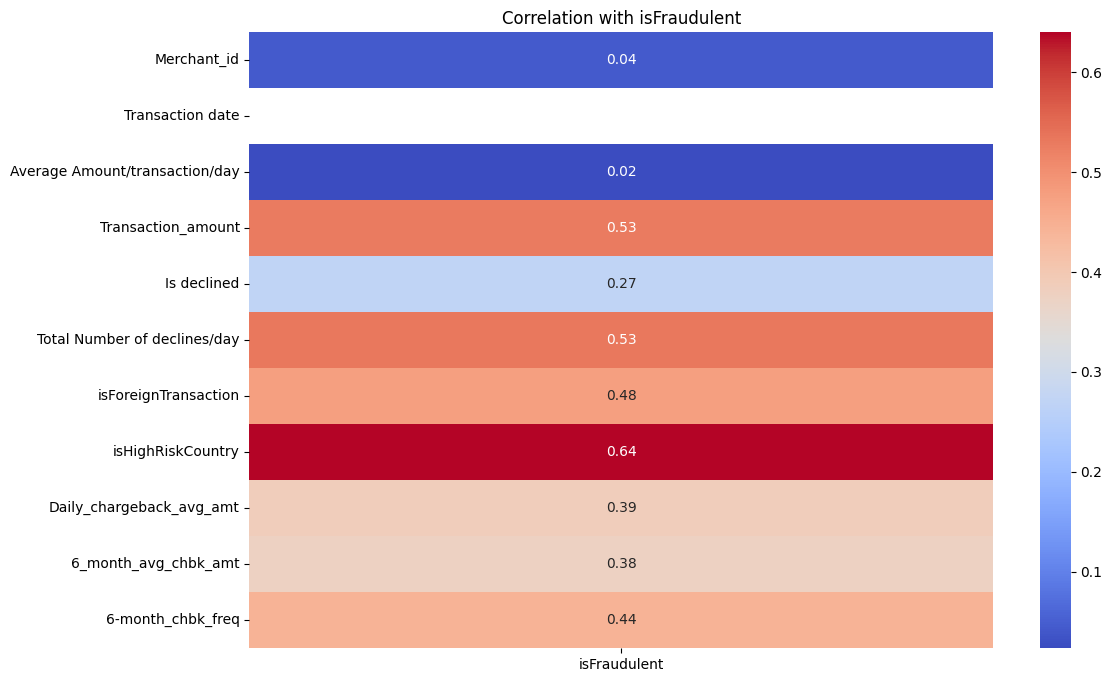

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation of all columns with 'isFraudulent'
correlations = data.corr()['isFraudulent']

# Remove 'isFraudulent' from the correlations (correlation with itself is 1)
correlations = correlations.drop('isFraudulent')

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))  # Adjust figure size as needed
sns.heatmap(correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with isFraudulent')
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [16]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

In [17]:
hnb_model = GaussianNB()
hnb_model.fit(X_resampled, y_resampled)

# Predict on test data
y_pred_hnb = hnb_model.predict(X_test_scaled)

# Evaluation metrics for HNB
accuracy_hnb = accuracy_score(y_test, y_pred_hnb)
precision_hnb = precision_score(y_test, y_pred_hnb)
recall_hnb = recall_score(y_test, y_pred_hnb)
f1_hnb = f1_score(y_test, y_pred_hnb)

print(f"HNB - Accuracy: {accuracy_hnb}, Precision: {precision_hnb}, Recall: {recall_hnb}, F1-Score: {f1_hnb}")

HNB - Accuracy: 0.9609882964889467, Precision: 0.8632478632478633, Recall: 0.8782608695652174, F1-Score: 0.8706896551724138


In [18]:
model = BayesianNetwork([('Transaction_amount', 'isFraudulent'),
                         ('isForeignTransaction', 'isFraudulent'),
                         ('isHighRiskCountry', 'isFraudulent'),
                         ('Total Number of declines/day', 'isFraudulent')])

X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
# Assuming X_resampled_df is your DataFrame and 'Transaction_amount' is a column you want to convert
X_resampled_df['Transaction_amount'] = X_resampled_df['Transaction_amount'].astype(int)

X_resampled_df['isFraudulent'] = y_resampled
# Train the model using Maximum Likelihood Estimator
model.fit(X_resampled_df, estimator=MaximumLikelihoodEstimator)


In [20]:
from sklearn.preprocessing import KBinsDiscretizer
inference = VariableElimination(model)
#valid_columns = ['Merchant_id', 'Transaction_amount', 'isHighRiskCountry']

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')  # Adjust parameters as needed

def predict_fraud(row, model, discretizer):
    # Discretize continuous evidence variables
    continuous_evidence = ['Transaction_amount']
    evidence_values = row[continuous_evidence].values.reshape(1, -1)  # Reshape for discretizer
    discretized_evidence = discretizer.fit_transform(evidence_values).astype(int)[0]  # Convert to integers
    evidence = {
        'Transaction_amount': discretized_evidence[0],  # Use discretized value
        'isForeignTransaction': int(row['isForeignTransaction']),  # Ensure integer type
        'isHighRiskCountry': int(row['isHighRiskCountry']), # Use discretized value
        'Total Number of declines/day': int(row['Total Number of declines/day'])
    }

    # Perform inference on the evidence provided
    inference = VariableElimination(model)
    result = inference.map_query(variables=['isFraudulent'], evidence=evidence)

    # Return the predicted class
    return result['isFraudulent']

# Apply the prediction function to the test set
X_test['PredictedFraud'] = X_test.apply(lambda row: predict_fraud(row, model, discretizer), axis=1)

# Step 8: Evaluate the model
y_pred = X_test['PredictedFraud']

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/site-packages/tqdm/_monitor.py", line 69, in run
    instances = self.get_instances()
  File "/opt/conda/lib/python3.10/site-packages/tqdm/_monitor.py", line 49, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/opt/conda/lib/python3.10/_weakrefset.py", line 97, in copy
    return self.__class__(self)
  File "/opt/conda/lib/python3.10/_weakrefset.py", line 51, in __init__
    self.update(data)
  File "/opt/conda/lib/python3.10/_weakrefset.py", line 124, in update
    for element in other:
  File "/opt/conda/lib/python3.10/_weakrefset.py", line 65, in __iter__


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
    for itemref in self.data:
RuntimeError: Set changed size during iteration


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:245: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [21]:
y_true = y_test.loc[y_pred.index]
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Precision
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision:.4f}')

# Recall
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall:.4f}')

# F1 Score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9454
Precision: 0.8842
Recall: 0.7304
F1 Score: 0.8000


In [ ]:
model.save('my_model.h5')  # Save your model to a file

In [ ]:
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# Create a DataFrame to store the metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'HNB': [accuracy_hnb, precision_hnb, recall_hnb, f1_hnb],
    'BBN': [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics_data)


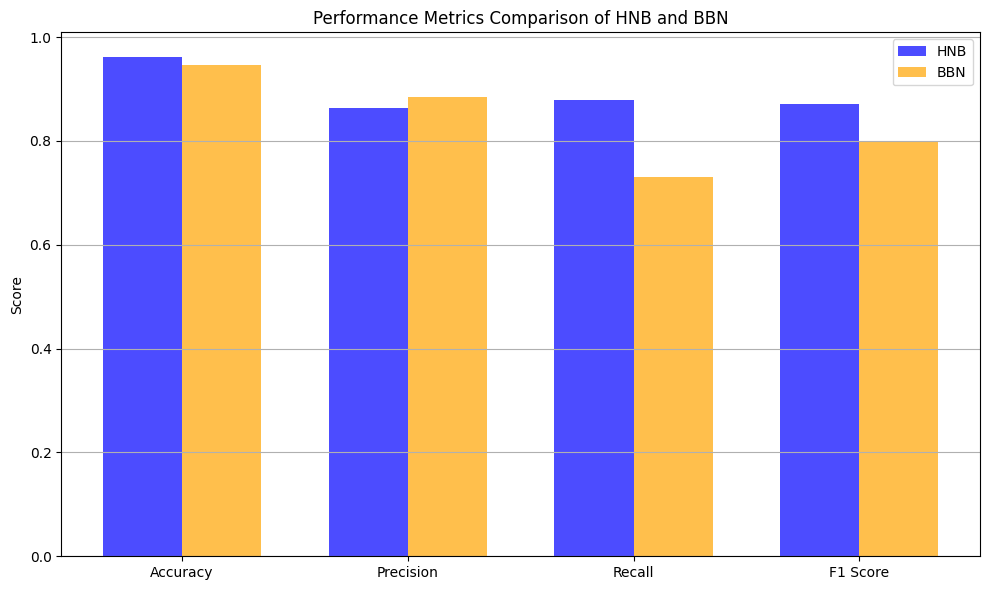

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Plot for Comparing HNB and BBN Metrics
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(metrics_df['Metric']))

plt.bar(x, metrics_df['HNB'], width=bar_width, label='HNB', color='blue', alpha=0.7)
plt.bar([p + bar_width for p in x], metrics_df['BBN'], width=bar_width, label='BBN', color='orange', alpha=0.7)

plt.xticks([p + bar_width / 2 for p in x], metrics_df['Metric'])
plt.ylabel('Score')
plt.title('Performance Metrics Comparison of HNB and BBN')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


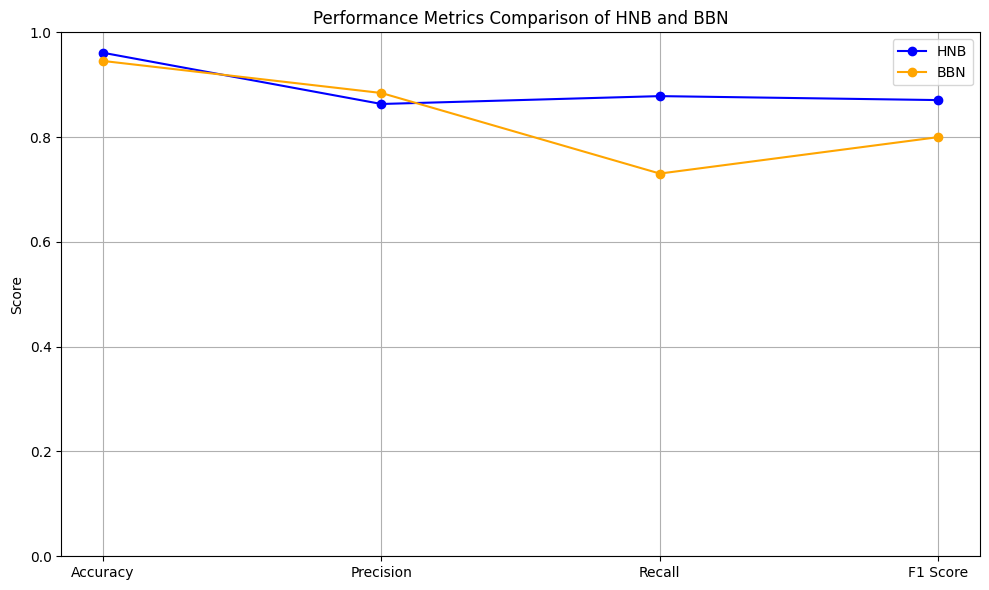

In [24]:
import matplotlib.pyplot as plt

# Assuming you have the metrics_df DataFrame from the previous example
plt.figure(figsize=(10, 6))

# Plotting the metrics for HNB
plt.plot(metrics_df['Metric'], metrics_df['HNB'], marker='o', label='HNB', color='blue')

# Plotting the metrics for BBN
plt.plot(metrics_df['Metric'], metrics_df['BBN'], marker='o', label='BBN', color='orange')

# Adding labels and title
plt.ylabel('Score')
plt.title('Performance Metrics Comparison of HNB and BBN')
plt.legend()
plt.grid()
plt.ylim(0, 1)  # Assuming metrics are between 0 and 1
plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import confusion_matrix
# For HNB
cm_hnb = confusion_matrix(y_test, y_pred_hnb)

# For BBN
cm_bbn = confusion_matrix(y_true, y_pred)  # Assuming y_true and y_pred are your BBN true and predicted values


In [26]:
print(f"Confusion matrix for HNB: {cm_hnb}")
print(f"Confusion matrix for BBN: {cm_bbn}")

Confusion matrix for HNB: [[638  16]
 [ 14 101]]
Confusion matrix for BBN: [[643  11]
 [ 31  84]]


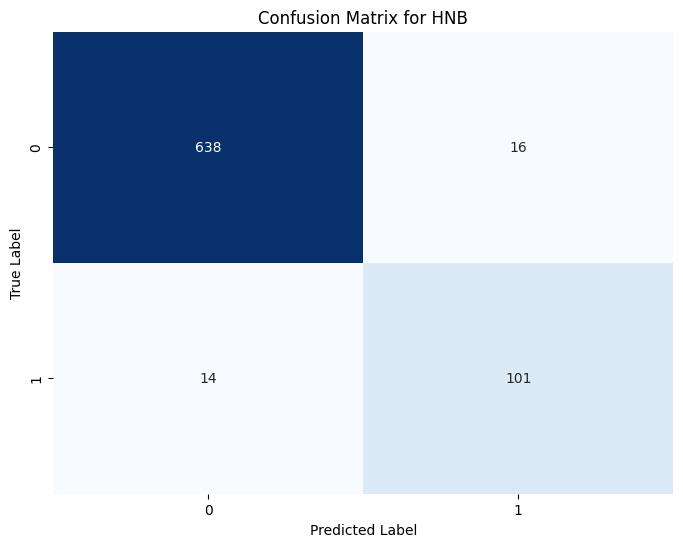

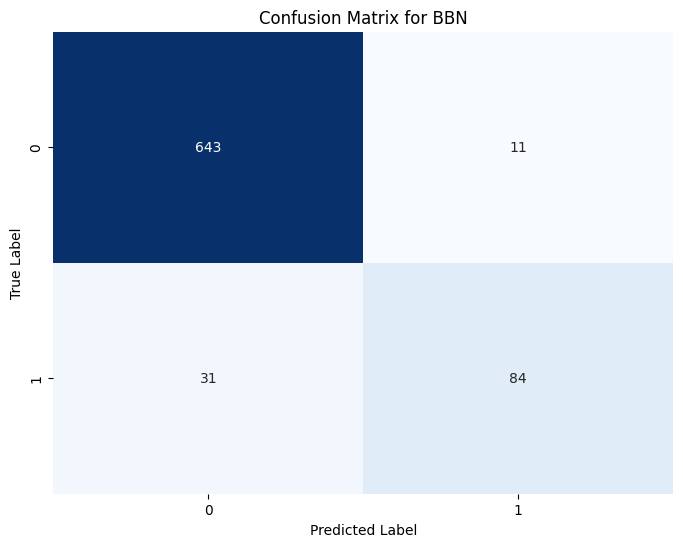

In [27]:
# For HNB
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hnb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for HNB")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# For BBN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bbn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for BBN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()